In [1]:
import pickle

import pandas as pd
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

from utils.decorators import show_elapsed_time
from utils.decorators import send_notification
from utils.metrics import compute_metrics
from utils.plots import plot_loss_and_metrics, print_metrics_table
import matplotlib.pyplot as plt
from constants import TRAIN_DATA_CSV, TEST_DATA_CSV, MLP_MODEL_PATH, TARGET_SCALER_PATH

In [2]:
df_train = pd.read_csv(TRAIN_DATA_CSV)
df_test = pd.read_csv(TEST_DATA_CSV)

with open(TARGET_SCALER_PATH, "rb") as f:
    target_encoder = pickle.load(f)


def reverse_target_encoding(targets):
    return target_encoder.inverse_transform(targets.reshape(-1, 1)).flatten()

In [3]:
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (17200, 14)
Test shape: (4300, 14)


# CONSTANTS

In [4]:
BATCH_SIZE = 1024
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class CarDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


train_dataset = CarDataset(df_train.drop(columns=["id", "price", "price_std", "description"]), df_train["price_std"])
test_dataset = CarDataset(df_test.drop(columns=["id", "price", "price_std", "description"]), df_test["price_std"])

print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train dataset length: 17200
Test dataset length: 4300


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [7]:
model = Net().to(DEVICE)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, min_lr=1e-9, patience=50)

trainSteps = len(train_loader.dataset) // BATCH_SIZE
testSteps = len(test_loader.dataset) // BATCH_SIZE
history = {"train_loss": [], "test_loss": []}
metrics_history = {"train_mae": [], "test_mae": [], "train_rmse": [], "test_rmse": [], "train_r2": [], "test_r2": [], "train_mse": [], "test_mse": []}

In [8]:
@show_elapsed_time
@send_notification
def train(num_epochs: int = 100):
    best_val_loss = float("inf")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        all_train_predictions = []
        all_train_ground_truths = []
        for i, (features, labels) in enumerate(train_loader):
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            outputs = outputs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            unnormed_outputs = reverse_target_encoding(outputs)
            unnormed_labels = reverse_target_encoding(labels)
            all_train_predictions.extend(unnormed_outputs)
            all_train_ground_truths.extend(unnormed_labels)

        train_metrics = compute_metrics(all_train_predictions, all_train_ground_truths)
        metrics_history["train_mae"].append(train_metrics["MAE"])
        metrics_history["train_mse"].append(train_metrics["MSE"])
        metrics_history["train_rmse"].append(train_metrics["RMSE"])
        metrics_history["train_r2"].append(train_metrics["R2"])

        model.eval()
        test_loss = 0.0
        all_test_predictions = []
        all_test_ground_truths = []
        with torch.no_grad():
            for i, (features, labels) in enumerate(test_loader):
                features, labels = features.to(DEVICE), labels.to(DEVICE)
                outputs = model(features)
                loss = criterion(outputs, labels.unsqueeze(1))
                test_loss += loss.item()
                outputs = outputs.cpu().detach().numpy()
                labels = labels.cpu().detach().numpy()
                unnormed_outputs = reverse_target_encoding(outputs)
                unnormed_labels = reverse_target_encoding(labels)
                all_test_predictions.extend(unnormed_outputs)
                all_test_ground_truths.extend(unnormed_labels)

        test_metrics = compute_metrics(all_test_predictions, all_test_ground_truths)
        metrics_history["test_mae"].append(test_metrics["MAE"])
        metrics_history["test_mse"].append(test_metrics["MSE"])
        metrics_history["test_rmse"].append(test_metrics["RMSE"])
        metrics_history["test_r2"].append(test_metrics["R2"])

        train_loss /= trainSteps
        test_loss /= testSteps

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)

        scheduler.step(test_loss)
        print(scheduler.get_last_lr())

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print("Train Metrics: ", train_metrics)
        print("Test Metrics: ", test_metrics)

        if test_loss < best_val_loss:
            best_val_loss = test_loss
            torch.save(model.state_dict(), MLP_MODEL_PATH)
            print(f"Epoch {epoch + 1}: New best test loss: {best_val_loss}")

In [9]:
train(2000)

[0.0001]
Epoch 1/2000, Train Loss: 0.7896, Test Loss: 0.8660
Train Metrics:  {'MAE': 6612.4365, 'MSE': 72401944.0, 'RMSE': 8508.934, 'R2': 0.08646329345060799}
Test Metrics:  {'MAE': 6167.1914, 'MSE': 65033308.0, 'RMSE': 8064.323, 'R2': 0.1693779419244824}
Epoch 1: New best test loss: 0.8660091012716293
[0.0001]
Epoch 2/2000, Train Loss: 0.7236, Test Loss: 0.7887
Train Metrics:  {'MAE': 6064.415, 'MSE': 62286376.0, 'RMSE': 7892.172, 'R2': 0.21409728761191693}
Test Metrics:  {'MAE': 5614.881, 'MSE': 55325620.0, 'RMSE': 7438.1196, 'R2': 0.2933670019514173}
Epoch 2: New best test loss: 0.7887056916952133
[0.0001]
Epoch 3/2000, Train Loss: 0.6604, Test Loss: 0.7101
Train Metrics:  {'MAE': 5533.3247, 'MSE': 53148852.0, 'RMSE': 7290.3257, 'R2': 0.3293906414076554}
Test Metrics:  {'MAE': 5052.5713, 'MSE': 46173670.0, 'RMSE': 6795.121, 'R2': 0.41025812506238124}
Epoch 3: New best test loss: 0.710090383887291
[0.0001]
Epoch 4/2000, Train Loss: 0.5933, Test Loss: 0.6282
Train Metrics:  {'MAE': 4

KeyboardInterrupt: 

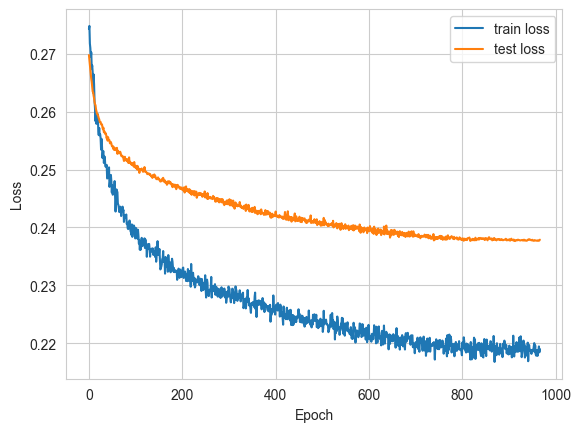

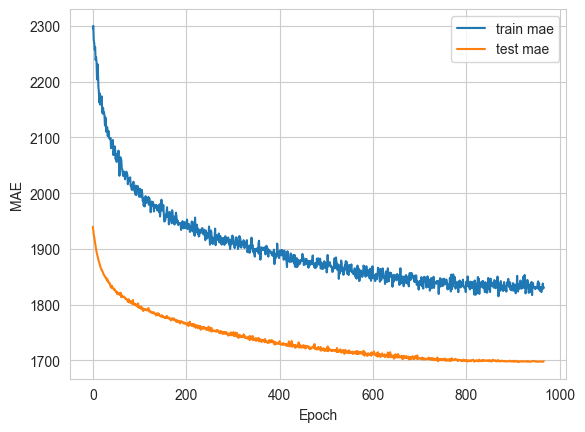

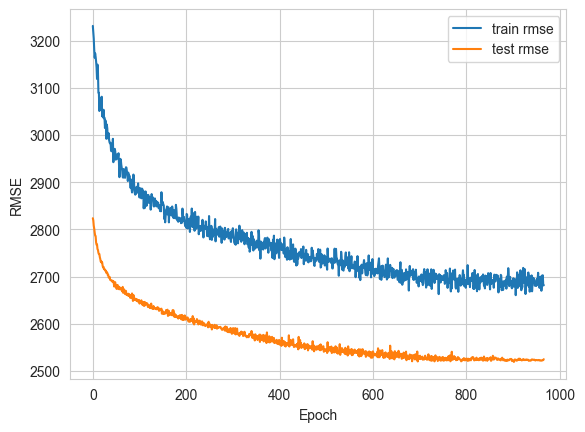

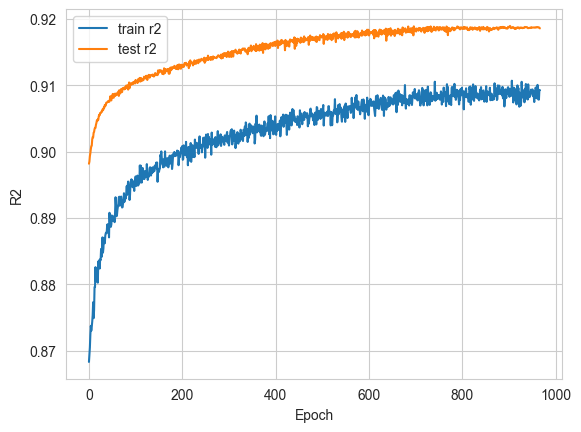

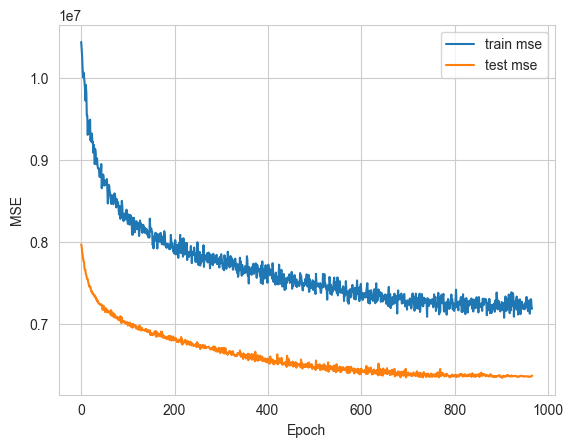

Train Metrics
+---------+---------+---------+---------+------------+
|   Epoch |     MAE |    RMSE |      R2 |        MSE |
+=========+=========+=========+=========+============+
|     986 | 1830.88 | 2681.66 | 0.90926 | 7.1913e+06 |
+---------+---------+---------+---------+------------+

Test Metrics
+---------+---------+---------+---------+-------------+
|   Epoch |     MAE |    RMSE |      R2 |         MSE |
+=========+=========+=========+=========+=============+
|     986 | 1698.73 | 2525.06 | 0.91856 | 6.37594e+06 |
+---------+---------+---------+---------+-------------+


In [10]:
plot_loss_and_metrics(history, metrics_history, SLICE_START=20)
print_metrics_table(metrics_history)

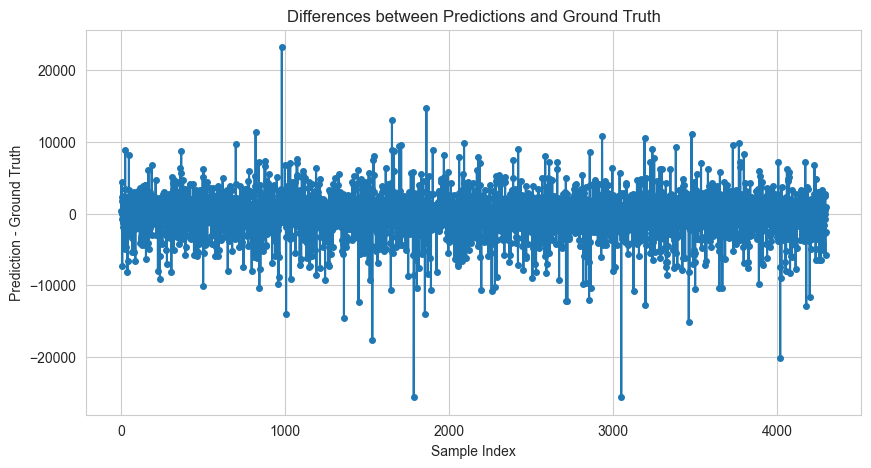

Average absolute difference: 1872.92


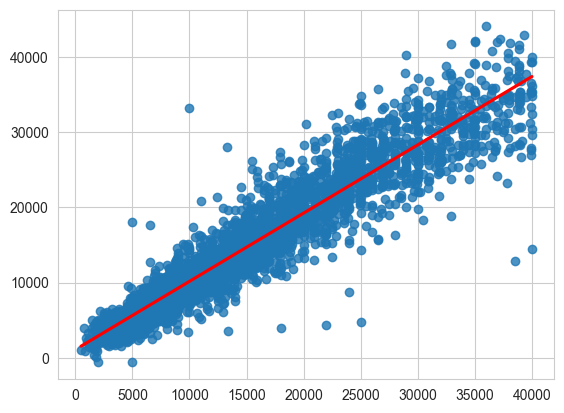

In [11]:
differences = []
abs_differences = []
gt = []
pred = []

with torch.no_grad():
    for inputs, targets in test_loader:  # Loop through the entire validation set
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        inputs = inputs.cpu().numpy()
        targets = targets.cpu().numpy()
        outputs = outputs.cpu().numpy()

        unnormed_outputs = reverse_target_encoding(outputs)
        unnormed_targets = reverse_target_encoding(targets)

        for output, target in zip(unnormed_outputs, unnormed_targets):
            diff = output - target  # Calculate the absolute difference
            abs_diff = abs(diff)  # Calculate the absolute difference
            differences.append(diff)  # Store the differences
            abs_differences.append(abs_diff)  # Store the absolute differences
            gt.append(target)
            pred.append(output)

# Plotting the differences
plt.figure(figsize=(10, 5))
plt.plot(differences, marker="o", linestyle="-", markersize=4)
plt.title("Differences between Predictions and Ground Truth")
plt.xlabel("Sample Index")
plt.ylabel("Prediction - Ground Truth")
plt.grid(True)
plt.show()

sns.regplot(x=gt, y=pred, ci=None, scatter=True, line_kws={"color": "red"})

# calculate the average difference
average_abs_diff = sum(abs_differences) / len(abs_differences)
print(f"Average absolute difference: {average_abs_diff:.2f}")